# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [3]:
customers = pd.read_csv("/content/drive/MyDrive/Zeotap/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Zeotap/Transactions.csv")

### Merge Customers and Transactions

In [4]:
transactions = transactions.merge(customers, on='CustomerID', how='left')

# Feature Engineering for Clustering

In [5]:
customer_features = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Region': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',  # Most common region
    'SignupDate': 'min',  # Signup date
}).reset_index()

# Process SignupDate to calculate the number of days since signup

In [6]:
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
customer_features['DaysSinceSignup'] = (pd.Timestamp.now() - customer_features['SignupDate']).dt.days
customer_features.drop('SignupDate', axis=1, inplace=True)

# Encode categorical features

In [7]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Scale numerical features

In [8]:
scaler = StandardScaler()
numerical_columns = ['TotalValue', 'Quantity', 'DaysSinceSignup']
customer_features[numerical_columns] = scaler.fit_transform(customer_features[numerical_columns])

# Clustering: Try different numbers of clusters from 2 to 10

In [9]:
db_scores = []
clusters_range = range(2, 11)
kmeans_models = []

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop('CustomerID', axis=1))
    kmeans_models.append(kmeans)
    db_score = davies_bouldin_score(customer_features.drop(['CustomerID', 'Cluster'], axis=1), customer_features['Cluster'])
    db_scores.append(db_score)

# Determine the optimal number of clusters based on DB Index

In [10]:
optimal_k = clusters_range[np.argmin(db_scores)]

print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k}")
print(f"Davies-Bouldin Index for each k: {db_scores}")

Optimal number of clusters based on Davies-Bouldin Index: 3
Davies-Bouldin Index for each k: [1.2339267409837922, 1.1940216453410988, 1.273772372822729, 1.2252455816464418, 1.2510383370363571, 1.3434001240152813, 1.3375262993835484, 1.364194852227647, 1.2861113329279972]


# Fit the optimal KMeans model

In [11]:
best_kmeans = kmeans_models[np.argmin(db_scores)]
customer_features['Cluster'] = best_kmeans.labels_


# Visualize Clusters

<ipython-input-12-0abbd9c4a4a3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(clusters_range), y=db_scores, palette='viridis')


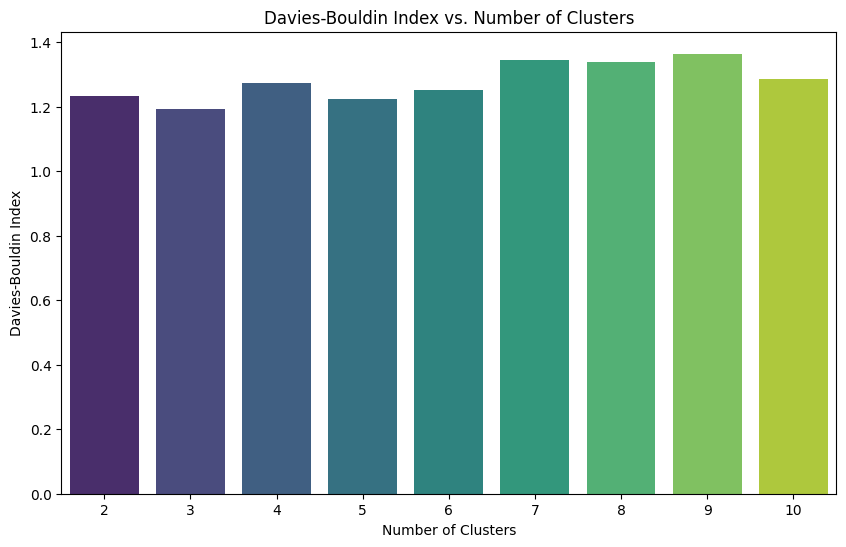

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(clusters_range), y=db_scores, palette='viridis')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [16]:
cluster_counts = customer_features['Cluster'].value_counts().sort_index()

# Display the number of customers per cluster
print("Number of customers per cluster:")
print(cluster_counts)

Number of customers per cluster:
Cluster
0    66
1    73
2    60
Name: count, dtype: int64


# Cluster-wise distribution of customers

<ipython-input-13-f157ca9e9166>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=customer_features, palette='viridis')


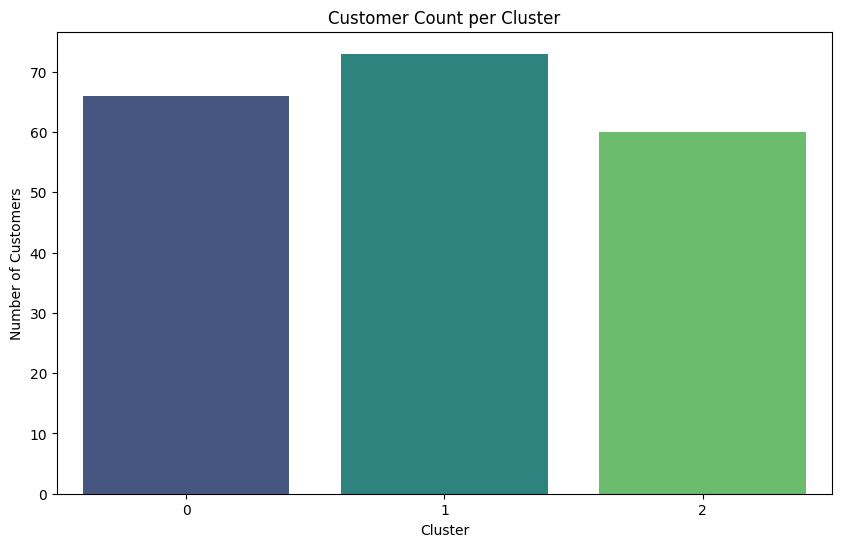

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# 2D visualization of clusters

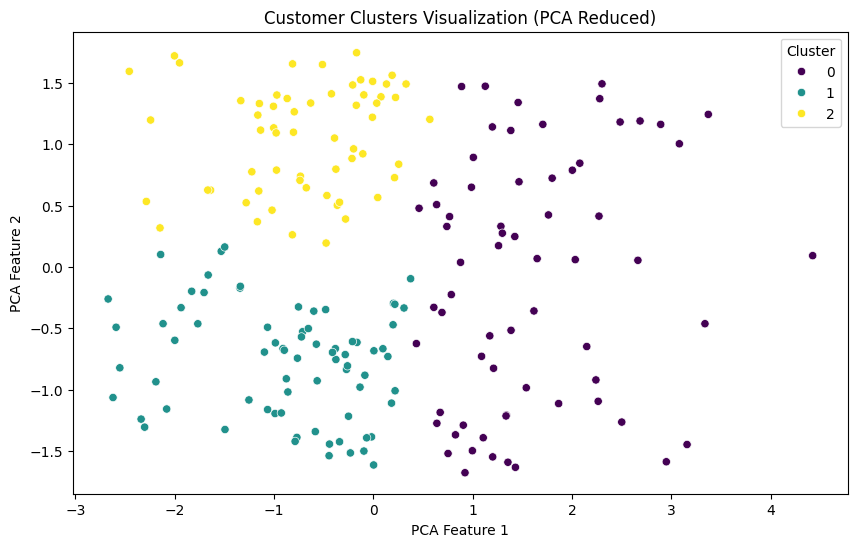

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features.drop(['CustomerID', 'Cluster'], axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_features['Cluster'],
    palette='viridis',
    legend='full'
)
plt.title('Customer Clusters Visualization (PCA Reduced)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

# Save clustering results

In [15]:
customer_features.to_csv("Customer_Clusters.csv", index=False)

print("Customer clustering completed. Results saved to 'Customer_Clusters.csv'.")

Customer clustering completed. Results saved to 'Customer_Clusters.csv'.
